### Import

In [1]:
import pandas as pd
import numpy as np
import os
import random

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

### DataLoad

In [6]:
# 학습 ChEMBL 데이터 로드
chembl_data = pd.read_csv('../rdkit_data/rdkit_train_corr_0.3.csv')  # 예시 파일 이름
chembl_data.head()

,pIC50,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,BCUT2D_LOGPLOW,BertzCT,Chi0,Chi0n,Chi0v,...,NOCount,NumAromaticCarbocycles,NumAromaticHeterocycles,NumHAcceptors,NumHeteroatoms,NumRotatableBonds,MolMR,fr_NH0,fr_benzene,fr_pyridine
0,10.59,535.624,501.352,535.270716,206,-2.500926,1405.892793,27.310826,22.307719,22.307719,...,10,1,2,8,11,7,144.7415,6,1,0
1,10.11,537.596,505.340,537.249981,206,-2.563125,1408.871656,27.310826,22.008861,22.008861,...,11,1,2,9,12,7,141.7095,6,1,0
2,10.09,545.566,515.326,545.236222,208,-2.476253,1382.863661,27.896612,21.649435,21.649435,...,10,1,2,8,13,8,137.9735,6,1,0
3,10.00,571.604,539.348,571.251873,218,-2.567951,1488.807437,29.103719,22.856542,22.856542,...,10,1,2,8,13,7,145.0715,6,1,0
4,10.00,473.537,446.321,473.217538,180,-2.455375,1448.073885,24.156125,19.769469,19.769469,...,10,1,3,8,10,4,129.4652,6,1,0


In [7]:
target = ['pIC50']
x = chembl_data.drop(target, axis = 1)
y = chembl_data.loc[:, target]

# 학습 및 검증 데이터 분리
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.3, random_state=42)

### Train & Validation

In [8]:
# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(random_state=CFG['SEED'])
model.fit(train_x, train_y)

c:\Users\ogong\anaconda3\envs\dacon\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [9]:
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

# Validation 데이터로부터의 학습 모델 평가
val_y_pred = model.predict(val_x)
mse = mean_squared_error(pIC50_to_IC50(val_y), pIC50_to_IC50(val_y_pred))
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')

RMSE: 2461.4331666495577


In [12]:
print(model.feature_importances_, '\n')

# 시리즈로 만들어 인덱스를 붙인다
ser = pd.Series(model.feature_importances_, index=x.columns)

# 내림차순 정렬을 이용한다
top = ser.sort_values(ascending=False)[:]
top10 = ser.sort_values(ascending=False)[:10]
print(top10)

[0.00555933 0.01004808 0.00415807 0.00252036 0.08689294 0.02411727
 0.02284765 0.01462105 0.00760976 0.00921449 0.01782472 0.04740252
 0.0198735  0.02850887 0.02111928 0.01066814 0.0203227  0.00621832
 0.00979277 0.04255693 0.02658447 0.03145797 0.02560892 0.04532991
 0.09939596 0.03048416 0.01084051 0.1137561  0.00134981 0.00437444
 0.00320508 0.12614392 0.00679714 0.00451672 0.01450114 0.01031312
 0.01603384 0.00261206 0.01481798] 

NumAromaticHeterocycles    0.126144
VSA_EState1                0.113756
SlogP_VSA5                 0.099396
BCUT2D_LOGPLOW             0.086893
Chi2n                      0.047403
SMR_VSA5                   0.045330
PEOE_VSA4                  0.042557
PEOE_VSA9                  0.031458
TPSA                       0.030484
HallKierAlpha              0.028509
dtype: float64


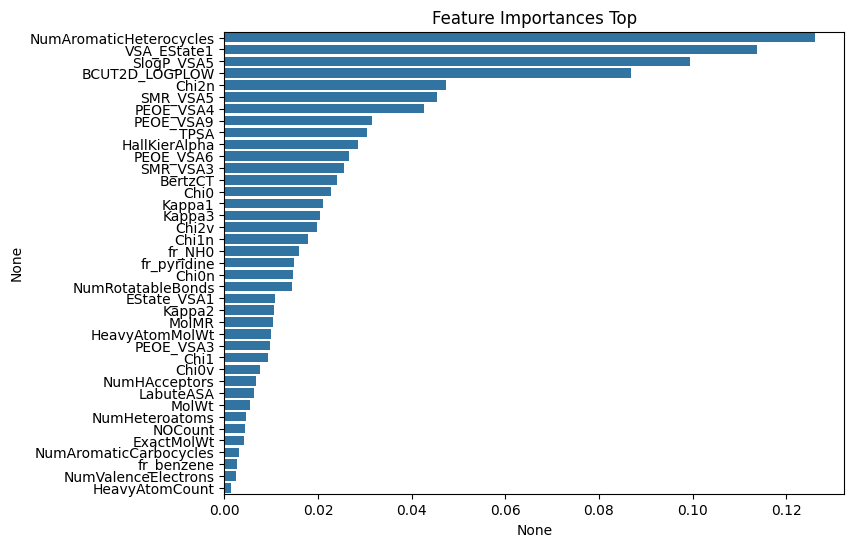

In [13]:
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top')
sns.barplot(x=top, y=top.index)
plt.show()

### Inference

In [10]:
test = pd.read_csv('./rdkit_test_corr_0.3.csv')

test_y_pred = model.predict(test)

### Submission

In [11]:
submit = pd.read_csv('./sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(test_y_pred)
submit.head()

,ID,IC50_nM
0,TEST_000,24.199144
1,TEST_001,40.117451
2,TEST_002,71.326350
3,TEST_003,22.418162
4,TEST_004,33.071204


In [12]:
submit.to_csv('./corr_0.3_submit.csv', index=False)